In [1]:
import numpy as np
import cv2 as cv
from collections import namedtuple
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imutils
import glob
import warnings
import os
import tqdm

In [2]:
TOL = 5
NUM_ITR = 1000
PATHS = namedtuple('_', ('mosaic', 'stereo'))('../images/Image Mosaicing/', '../images/Stereo Correspondence/')

def read_files_q1(idx):
    files = sorted(glob.glob(PATHS.mosaic + str(idx) +'_*'))
    images = []
    for f in files:
        img = cv.imread(f)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
        images.append(img)
    return images

In [3]:
def get_matches(img1, img2):
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # match
    flann = cv.FlannBasedMatcher({'algorithm': 1, 'trees': 5}, {'checks': 50})
    matches_raw = flann.knnMatch(des1, des2, k=2)

    matches = []
    for m in matches_raw:
        if m[0].distance < 0.7 * m[1].distance:
            matches.append(m)
    
    points1 = np.array([kp1[m[0].queryIdx].pt for m in matches], dtype=np.float64)
    points2 = np.array([kp2[m[0].trainIdx].pt for m in matches], dtype=np.float64)

    return points1, points2

def find_homography(src, dst):
    
    A = [[] for i in range(2 * src.shape[0])]

    for i in range(src.shape[0]):
        Xi = src[i]
        xi = dst[i]
        A[2 * i] = [Xi[0], Xi[1], 1, 0, 0, 0, -xi[0]*Xi[0], -xi[0]*Xi[1], -xi[0]]
        A[(2 * i) + 1] = [0, 0, 0, Xi[0], Xi[1], 1, -xi[1]*Xi[0], -xi[1]*Xi[1], -xi[1]]

    A = np.array(A, dtype=np.float64)
    u, d, vh = np.linalg.svd(A)

    if vh is None:
        warnings.warn('Could not compute H')
        return np.eye(3)

    H = vh[8].reshape((3, 3))
    H = H / H[2, 2]
    return H

def to_homogenous(x):
    return np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)


def project_points(P, X):
    X_ = to_homogenous(X)
    x = P @ X_.T
    x = x / x[2]
    return x.T[:, :2]

def find_homography_ransac(src, dst, tol=TOL, num_itr=NUM_ITR):
    
    best_H = None
    best_thresh = 0

    for i in range(num_itr):
        rand_idx = np.random.choice(dst.shape[0], size=5, replace=False)
        dst_r = dst[rand_idx, :]
        src_r = src[rand_idx, :]

        H = find_homography(src_r, dst_r)
        pred_dst = project_points(H, src)

        count = 0
        for i in range(src.shape[0]):
            e = np.linalg.norm(pred_dst[i, :] - dst[i, :])
            if e < tol:
                count += 1
        
        if count/src.shape[0] >= best_thresh:
            best_H = H
            best_thresh = count/src.shape[0]

    return best_H


In [21]:
def crop(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY)

    cnts = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv.contourArea)
    (x, y, w, h) = cv.boundingRect(c)
    img = img[y:y + h, x:x + w]
    return img

def overlap(img_bot, img_top):
    # pick pixels from img_top and place on img_bot
    for i in range(img_top.shape[0]):
        for j in range(img_top.shape[1]):
            if list(img_bot[i, j, :]) == [0, 0, 0]: # if bottom is black, freely replace
                img_bot[i, j, :] = img_top[i, j, :]
            elif list(img_top[i, j, :]) != [0, 0, 0]: # if bottom is not black, only replace if top is also not black
                img_bot[i, j, :] = img_top[i, j, :]
    return img_bot

def get_dim(img1, H, img2):
    corners1 = np.array([
        [0,                         0],
        [0,             img1.shape[0]],
        [img1.shape[1], img1.shape[0]],
        [img1.shape[1],             0],
    ], dtype=np.float64)
    
    corners1 = project_points(H, corners1)
    
    corners2 = np.array([
        [0,                         0],
        [0,             img2.shape[0]],
        [img2.shape[1], img2.shape[0]],
        [img2.shape[1],             0],
    ], dtype=np.float64)
    
    x_cords = np.concatenate((corners1[:, 0], corners2[:, 0]))
    y_cords = np.concatenate((corners1[:, 1], corners2[:, 1]))
    
    width = int(np.ceil(np.max(x_cords) - np.min(x_cords)))
    height = int(np.ceil(np.max(y_cords) - np.min(y_cords)))
    return width, height
    

def stitch_two(img1, img2): # img1 is new, img2 is base
    points1, points2 = get_matches(img1, img2)
    H = find_homography_ransac(points1, points2)
    
    width, height = get_dim(img1, H, img2)
    
#     result_width = int(np.floor(1.5 * (img1.shape[1] + img2.shape[1])))
#     result_height = int(np.floor(1.5 * (img1.shape[0] + img2.shape[0])))

    img1_ = cv.warpPerspective(img1, H, (width, height))
    img2 = crop(img2)
    return overlap(img1_, img2)

In [22]:
def panaroma(images):
    if len(images) == 0:
        return
    
    base = images[0]
    for img in tqdm.tqdm(images[1:]):
        base = stitch_two(img, base)
        

    return crop(base)

100%|██████████| 3/3 [11:14<00:00, 224.83s/it]


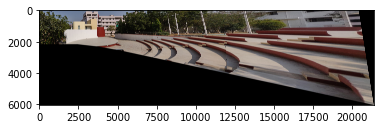

In [28]:
images = read_files_q1(1)
img = panaroma(images)
plt.imshow(img)

100%|██████████| 5/5 [00:47<00:00,  9.56s/it]


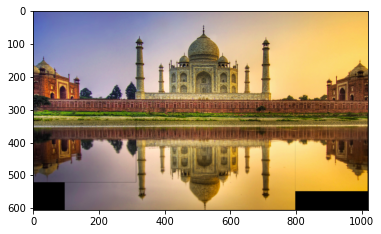

In [25]:
images = read_files_q1(2)
img = panaroma(images)
plt.imshow(img)

100%|██████████| 1/1 [00:08<00:00,  8.28s/it]


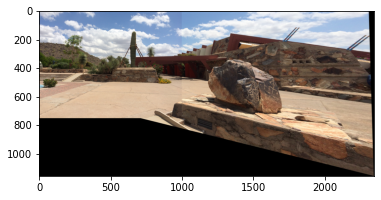

In [23]:
images = read_files_q1(3)
img = panaroma(images)
plt.imshow(img)

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


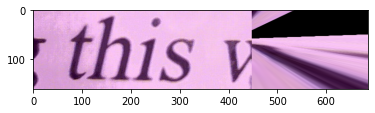

In [26]:
images = read_files_q1(4)
img = panaroma(images)
plt.imshow(img)

100%|██████████| 3/3 [08:14<00:00, 164.79s/it]


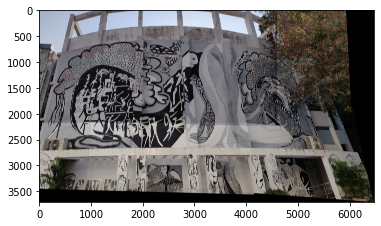

In [27]:
images = read_files_q1(5)
img = panaroma(images)
plt.imshow(img)